Machine learning models are models that *fit functions to data*

*how do we fit a function to data?*

let's see a much simplier example, a quadratic function be fitted into a certain random cuadratic points

In [40]:
from utils import *

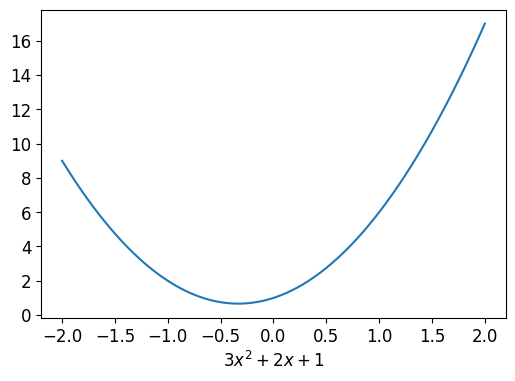

In [41]:
def f(x): return 3*x**2 + 2*x + 1

plot_function(f, "$3x^2 + 2x + 1$")

In [42]:
def quad(a,b,c, x): return a*x**2+b*x+c

In [43]:
quad(3,2,1, 1.5)

10.75

In [44]:
from functools import partial

# basically I want the function but with fixed values
def mk_quad(a,b,c): return partial(quad, a,b,c)

In [45]:
f = mk_quad(3,2,1)
f(1.5) # the same that the above cell but only passing x value because set fixed coeficient's values

10.75

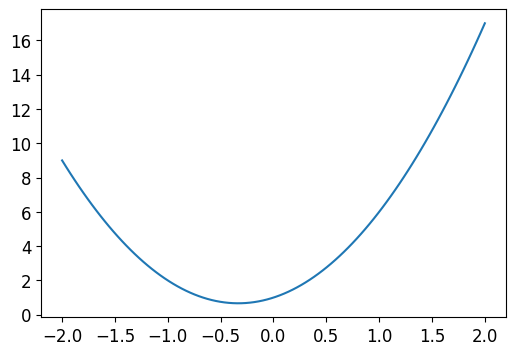

In [46]:
plot_function(f)

now we're going to generate data that matches the shape of the function, with some noise

In [47]:
from numpy.random import normal, seed, uniform

np.random.seed(42)
def noise(x, scale): return normal(scale=scale, size=x.shape)
def add_noise(x, mult, add): return x*(1+noise(x, mult)) + noise(x,add)

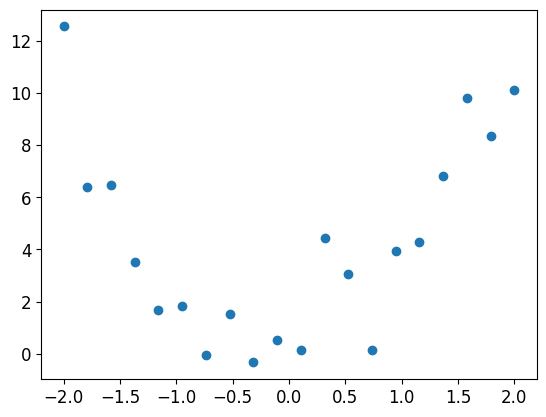

In [48]:
x = torch.linspace(-2,2, steps=20)[:,None]
y = add_noise(f(x), 0.3, 1.5)
plt.scatter(x,y)

Now the idea is find a curve that matches the data.

Manually we can tuning the parameters to try fit better the data.

As a first approach the only way to know if the function parameters fits better is through visual inspection.

In [49]:
from ipywidgets import interact
@interact(a=1.5, b=1.5, c=1.5)
def plot_quad(a, b, c):
    plt.scatter(x, y)
    plot_function(mk_quad(a,b,c))

interactive(children=(FloatSlider(value=1.5, description='a', max=4.5, min=-1.5), FloatSlider(value=1.5, descr…

The previous is, essentially, the core idea of fit a model to certain data, but in much rudimentary implementation.

Now, we need something to measure to see if we're getting better or worse in our parameter fitting. 

One metric for this is called 'mean squared error', which is defined as follow:

In [50]:
def mse(preds, acts): return ((preds-acts)**2).mean()

now if we plot the function again, but this time I'm going to calculate the LOSS Function (mse) for each set of parameters, 

This is a more rigorous approach, still manual, but we have a metric (loss function) of which we could stand on.

In [51]:
@interact(a=1.5, b=1.5, c=1.5)
def plot_quad(a, b, c):
    f = mk_quad(a,b,c)
    plt.scatter(x, y)
    loss = mse(f(x), y)
    plot_function(f, title=f'MSE: {loss:.2f}')

interactive(children=(FloatSlider(value=1.5, description='a', max=4.5, min=-1.5), FloatSlider(value=1.5, descr…

Now we need to automate the parameter adjusting.
One approach faster is to calculate it's derivative. In short, the derivative is a function that tells you if you increase the input does the output increse, it's called the slope or the gradient.

Pytorch automatically calculate it for us, 

In [57]:
def quad_mse(params):
    f = mk_quad(*params)
    return mse(f(x),y)

In [58]:
# let's try the function
quad_mse([1.5, 1.5, 1.5])

# P.S: In pytorch everything is a tensor. 

tensor(5.8336, dtype=torch.float64)

now, we're going to create the default parameters of the tensor as a,b,c (1.5, 1.5, 1.5 as defualt initilization)
and then we're going to tell pytorch that we need to calculate tge gradient of the tensor.

In [59]:
abc = torch.tensor([1.5, 1.5, 1.5]) #rank 1 tensor
abc.requires_grad_() # 


tensor([1.5000, 1.5000, 1.5000], requires_grad=True)

In [60]:
loss = quad_mse(abc)
loss # Pytorch tell us that if we wanted to, Pytorch know how to calculate the gradients, using backward

tensor(5.8336, dtype=torch.float64, grad_fn=<MeanBackward0>)

the following cell tell us that, if we increase the first parameter, the loss will decrease, 

if we decrease the 2nd parameter, the loss will decrease, 

and if we increase the third parameter, the loss will decrease as well. 

In [61]:
loss.backward()

abc.grad

tensor([-5.1419,  2.8472, -1.1009])

now we need to automate the changes so it could be approximating automatically.


This is basically the standard way of how deep learning libraries used to minimize loss function to each layer for a deep neural net model

In [62]:
with torch.no_grad():
    abc -= abc.grad*0.01
    loss = quad_mse(abc)

print(f'loss={loss:.2f}')

loss=5.49


In [63]:
for i in range(5):
    loss = quad_mse(abc)
    loss.backward()
    with torch.no_grad(): abc -= abc.grad*0.01
    print(f'step={i}; loss={loss:.2f}')


step=0; loss=5.49
step=1; loss=4.90
step=2; loss=4.23
step=3; loss=3.67
step=4; loss=3.33


we now have optimizaed coeficients

In [64]:
abc

tensor([2.3077, 0.9588, 1.6227], requires_grad=True)

This is basically how optimization is done. 

This principle is called 'Gradient descent'.

This is (in a nutshell) how parameters are setted.

Commonly we're going to use many kinds of functions, not only quadratics, we're going to need a way of generate the functions. And a way, of many others, to achieve that task is through a function called Rectified Linear Unit (ReLU). THe function takes 2 paramets, and basically it throws a linear function that goes to zero any number that is below to 0.

In [65]:
def rectified_linear(m, b, x):
    y = m*x+b
    return torch.clip(y, 0.)

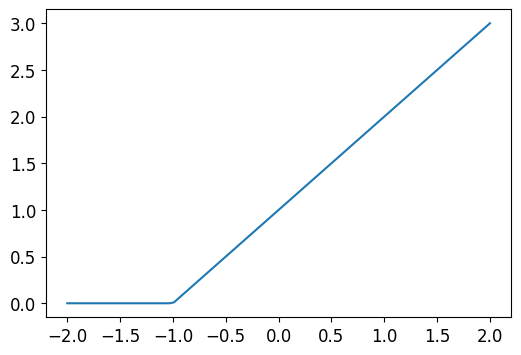

In [66]:
plot_function(partial(rectified_linear, 1, 1))

In [67]:
@interact(m=1.5, b=1.5)
def plot_relu(m, b):
    plot_function(partial(rectified_linear, m, b), )

interactive(children=(FloatSlider(value=1.5, description='m', max=4.5, min=-1.5), FloatSlider(value=1.5, descr…

why is this function interesting?
what we could do, is taking that ReLU function and connect another one, 

In [68]:
def double_relu(m1, b1, m2, b2, x):
    return rectified_linear(m1, b1, x) + rectified_linear(m2, b2, x)

In [70]:
@interact(m1=-1.5, b1=-1.5, m2=1.5, b2=1.5)
def plot_relu(m1, b1, m2, b2):
    plot_function(partial(double_relu, m1, b1, m2, b2), )

interactive(children=(FloatSlider(value=-1.5, description='m1', max=1.5, min=-4.5), FloatSlider(value=-1.5, de…

The above is interesting, because we could add many ReLUs functions as we want. 
We could create a certain function that approximate (and minimize the loss) as possible.

If we add a hundred million ReLUs added together much probably (and exaggerately) we would reach a certain level of close of the function that we want to approximate.

With this incredible simple fundation we could build models.

Everything from now on, it tweeaks to make faster, make bigger, this is it